In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

import sys, os
sys.path.insert(0, "/home/storage/hans/jax_reco_new")
from lib.plotting import adjust_plot_1d
from lib.simdata_i3 import I3SimHandler
import pandas as pd

In [2]:
bp = '/home/storage/hans/jax_reco_new/examples/reco_realtime/update/delta_logl/large_scale/results/'

# starting events
# [8, 1722, 9410, 19455, 21663, 25632, 27285, 32839, 40023, 51687, 57174, 59010, 59228, 63373]

In [3]:
def get_cdf(logls, bins):
    logls.sort()
    n = len(logls)
    j = 0 # indexes into logl
    cdf_vals = np.zeros(len(bins)-1)
    count = 0
    for i in range(1, len(bins)):
        x = bins[i]
        while j < len(logls) and logls[j] <= x:
            count += 1
            j += 1

        cdf_vals[i-1] = float(count) / float(n)
        
    return cdf_vals

def get_hist(dat, bins):
    logls = dat[:, 0]
    return get_cdf(logls, bins), logls[-1]

In [4]:
starting_events = set([8, 1722, 9410, 19455, 21663, 25632, 27285, 32839, 40023, 51687, 57174, 59010, 59228, 63373])

In [5]:
event_ids = ['1022', '10393', '10644', '10738', '11086', '11232', '13011',
       '13945', '14017', '14230', '15243', '16416', '16443', '1663',
       '1722', '17475', '18846', '19455', '20027', '21113', '21663',
       '22232', '22510', '22617', '23574', '23638', '23862', '24530',
       '24726', '25181', '25596', '25632', '27063', '27188', '27285',
       '28188', '28400', '29040', '29707', '3062', '31920', '31989',
       '32781', '32839', '33119', '33656', '34506', '35349', '37086',
       '37263', '37448', '37786', '37811', '39166', '39962', '40023',
       '41381', '41586', '42566', '42568', '42677', '43153', '43483',
       '4397', '44081', '48309', '48448', '48632', '49067', '50832',
       '51687', '51956', '54374', '55301', '55526', '55533', '56041',
       '5620', '56741', '56774', '57174', '57394', '57723', '59010',
       '59029', '59089', '59099', '59228', '62274', '62512', '63373',
       '65472', '6586', '8', '8604', '8674', '8840', '9410', '9419',
       '9505']

bins = np.linspace(0.0, 100.0, 400)
bins_plot = bins + 0.5 * (bins[1] - bins[0])
binc_plot = 0.5*(bins_plot[1:] + bins_plot[:-1])


In [6]:
cdfs_corr = []
succ_ids = []

for event_id in event_ids:
    if int(event_id) in starting_events:
        continue
    try:
        dat_filter_prepulse_corr = np.load(os.path.join(bp, "sigma_0.7", f"llh_results_event_{event_id}_padded_input.npy"))
    except:
        continue
        
    cdf, _ = cdf_filter_prepulse_corr, m3 = get_hist(dat_filter_prepulse_corr, bins)
    if cdf[50] > 0.1:
        succ_ids.append(event_id)
    else:
        continue
    cdfs_corr.append(cdf)

In [7]:
cdfs_corr[0].shape

(399,)

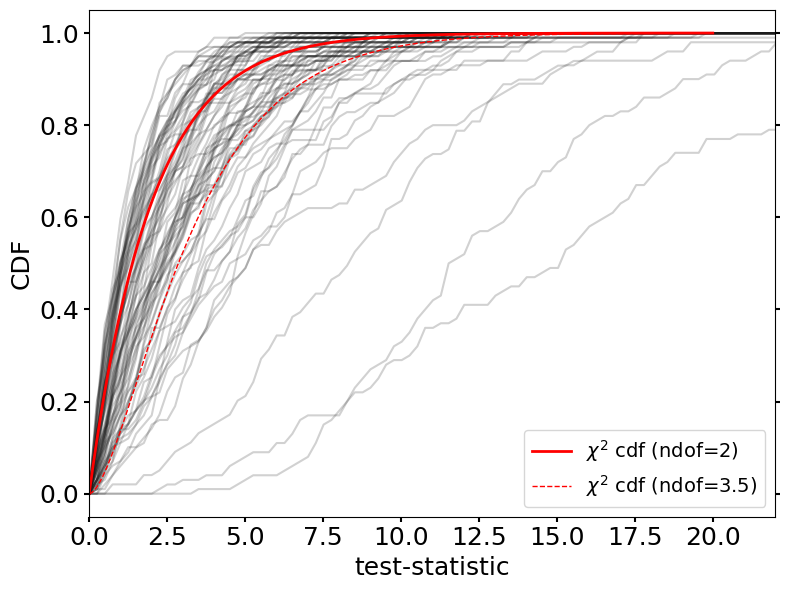

In [8]:
xvals = np.linspace(0.0, 20, 1000)
yvals = chi2.cdf(xvals, 2)
yvals2 = chi2.cdf(xvals, 3.5)

plt.figure(figsize=(8,6))

for cdf in cdfs_corr:
    plt.plot(bins, np.concatenate([np.array([0]), cdf]), alpha=0.2, color='0.1')
    #plt.hist(binc_plot, bins=bins_plot, weights=cdf, histtype='step', alpha=0.4)


plt.plot(xvals, yvals, 'r-', label='$\\chi^2$ cdf (ndof=2)', lw=2)
plt.plot(xvals, yvals2, 'r--', label='$\\chi^2$ cdf (ndof=3.5)', lw=1)
plt.xlim([0.0, 22])
plt.legend(loc='lower right', fontsize=14)
plt.ylabel('CDF', fontsize=18)
plt.xlabel('test-statistic', fontsize=18)

ax = plt.gca()
#ax.axhline(y=0.9, color="tab:orange", linestyle='dotted', lw=1)
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=18)
ax.yaxis.set_ticks_position('both')
plt.tight_layout()
plt.show()

In [9]:
from bisect import bisect_left
search_bins = bins[1:].copy()

pval = 0.68
crit_vals = []
for cdf in cdfs_corr:
    i = bisect_left(cdf.tolist(), pval)
    x = 0.5*(search_bins[i]+search_bins[i-1])
    #print(0.5*(cdf[i]+cdf[i-1]))
    crit_vals.append(x)

In [10]:
print(search_bins.shape)

(399,)


In [11]:
print(cdf.shape)

(399,)


In [12]:
print(cdfs_corr[0].shape)

(399,)


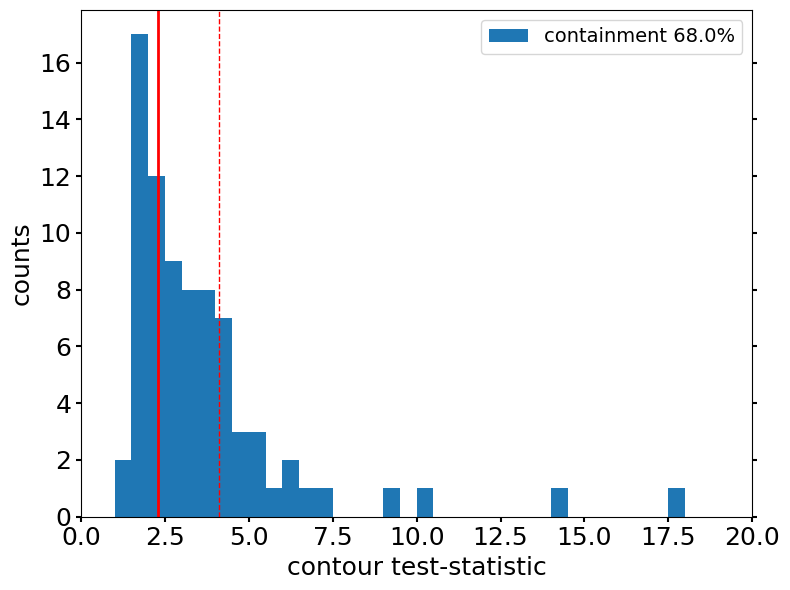

In [13]:
plt.figure(figsize=(8,6))
bins_c = np.linspace(0.0, 20.0, 41)
plt.hist(crit_vals, bins=bins_c, label=f'containment {pval*100}%')
plt.xlim([0.0, 20])
plt.legend(loc='upper right', fontsize=14)
plt.ylabel('counts', fontsize=18)
plt.xlabel('contour test-statistic', fontsize=18)

ax = plt.gca()
ax.axvline(x=chi2.isf(1-pval, 2), color='red', lw=2)
ax.axvline(x=chi2.isf(1-pval, 3.5), color='red', lw=1, linestyle='dashed')
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=18)
ax.yaxis.set_ticks_position('both')
plt.tight_layout()
plt.show()

In [14]:
for s_id, crit_val in zip(succ_ids, crit_vals):
    if crit_val > 5:
        print(s_id)

13945
22510
28400
32781
33656
37263
42568
48309
48632
49067
56041
62274


In [15]:
from bisect import bisect_left
search_bins = bins[1:].copy()

pval = 0.9
crit_vals = []
for cdf in cdfs_corr:
    i = bisect_left(cdf, pval)
    x = 0.5*(search_bins[i]+search_bins[i-1])
    if x > 20:
        x = 20
    #print(0.5*(cdf[i]+cdf[i-1]))
    crit_vals.append(x)

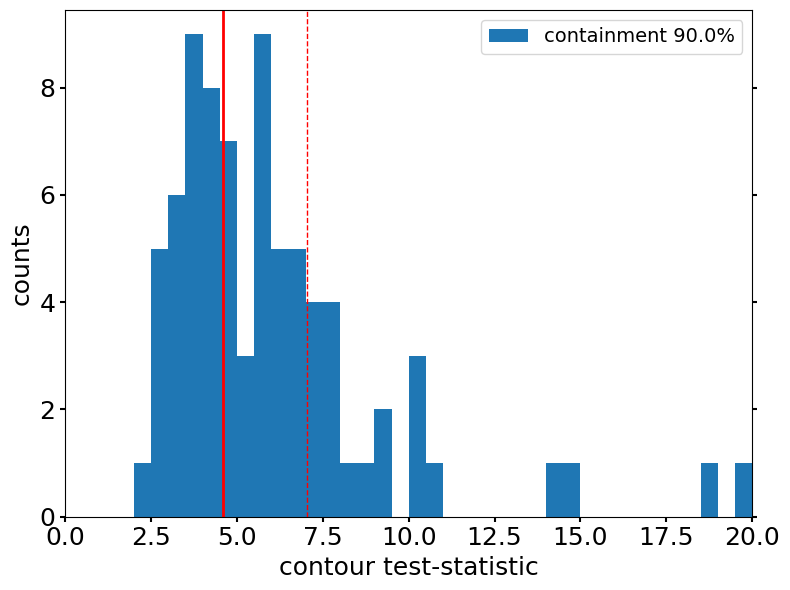

In [16]:
plt.figure(figsize=(8,6))
plt.hist(crit_vals, bins=bins_c, label=f'containment {pval*100}%')
plt.xlim([0.0, 20])
plt.legend(loc='upper right', fontsize=14)
plt.ylabel('counts', fontsize=18)
plt.xlabel('contour test-statistic', fontsize=18)

ax = plt.gca()
ax.axvline(x=chi2.isf(1-pval, 2), color='red', lw=2)
ax.axvline(x=chi2.isf(1-pval, 3.5), color='red', lw=1, linestyle='dashed')
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=18)
ax.yaxis.set_ticks_position('both')
plt.tight_layout()
plt.show()

In [17]:
cdfs = []

for event_id in succ_ids:
    if int(event_id) in starting_events:
        continue
    try:
        dat_filter_prepulse_corr = np.load(os.path.join(bp, "original", f"llh_results_event_{event_id}_padded_input.npy"))
    except:
        continue

    cdf, _ = cdf_filter_prepulse_corr, m3 = get_hist(dat_filter_prepulse_corr, bins)
    cdfs.append(cdf)

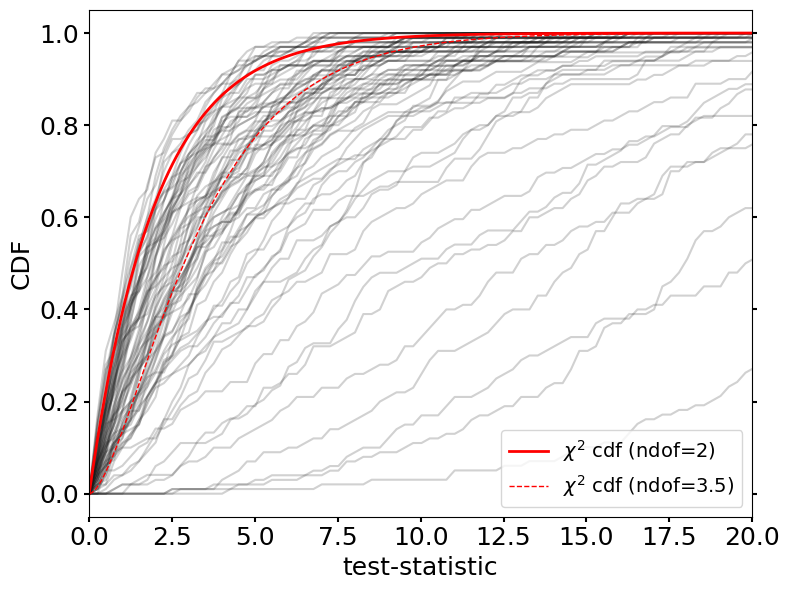

In [18]:
xvals = np.linspace(0.0, 20, 1000)
yvals = chi2.cdf(xvals, 2)
yvals2 = chi2.cdf(xvals, 3.5)

plt.figure(figsize=(8,6))

for cdf in cdfs:
    plt.plot(bins, np.concatenate([np.array([0]), cdf]), alpha=0.2, color='0.1')
    #plt.hist(binc_plot, bins=bins_plot, weights=cdf, histtype='step', alpha=0.4)


plt.plot(xvals, yvals, 'r-', label='$\\chi^2$ cdf (ndof=2)', lw=2)
plt.plot(xvals, yvals2, 'r--', label='$\\chi^2$ cdf (ndof=3.5)', lw=1)
plt.xlim([0.0, 20])
plt.legend(loc='lower right', fontsize=14)
plt.ylabel('CDF', fontsize=18)
plt.xlabel('test-statistic', fontsize=18)

ax = plt.gca()
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=18)
ax.yaxis.set_ticks_position('both')
plt.tight_layout()
plt.show()

In [19]:
from bisect import bisect_left
search_bins = bins[1:].copy()

pval = 0.68
crit_vals = []
for cdf in cdfs:
    i = bisect_left(cdf, pval)
    x = 0.5*(search_bins[i]+search_bins[i-1])
    if x > 20:
        x=20.0
    #print(0.5*(cdf[i]+cdf[i-1]))
    crit_vals.append(x)

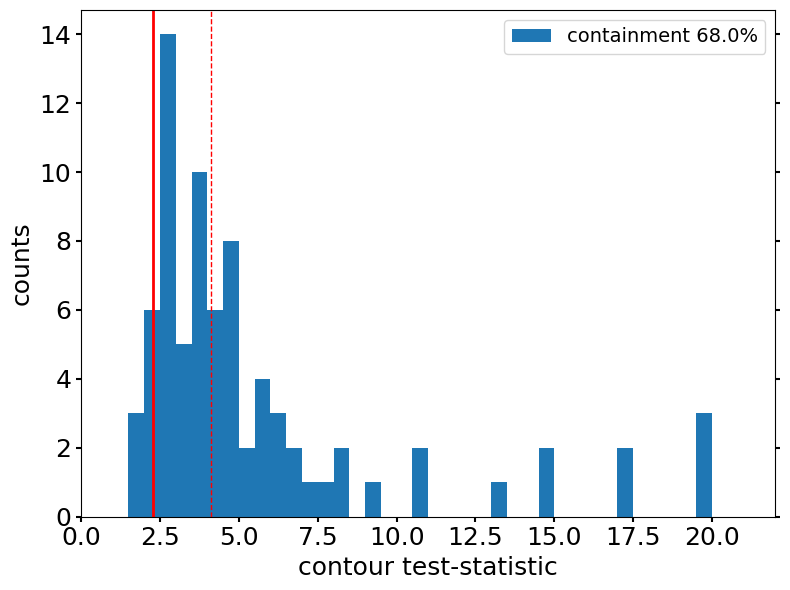

In [20]:
plt.figure(figsize=(8,6))
plt.hist(crit_vals, bins=bins_c, label=f'containment {pval*100}%')
plt.xlim([0.0, 22])
plt.legend(loc='upper right', fontsize=14)
plt.ylabel('counts', fontsize=18)
plt.xlabel('contour test-statistic', fontsize=18)

ax = plt.gca()
ax.axvline(x=chi2.isf(1-pval, 2), color='red', lw=2)
ax.axvline(x=chi2.isf(1-pval, 3.5), color='red', lw=1, linestyle='dashed')
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=18)
ax.yaxis.set_ticks_position('both')
plt.tight_layout()
plt.show()

In [21]:
from bisect import bisect_left
search_bins = bins[1:].copy()

pval = 0.9
crit_vals = []
for cdf in cdfs:
    i = bisect_left(cdf, pval)
    x = 0.5*(search_bins[i]+search_bins[i-1])
    if x > 20:
        x=20.0
    #print(0.5*(cdf[i]+cdf[i-1]))
    crit_vals.append(x)

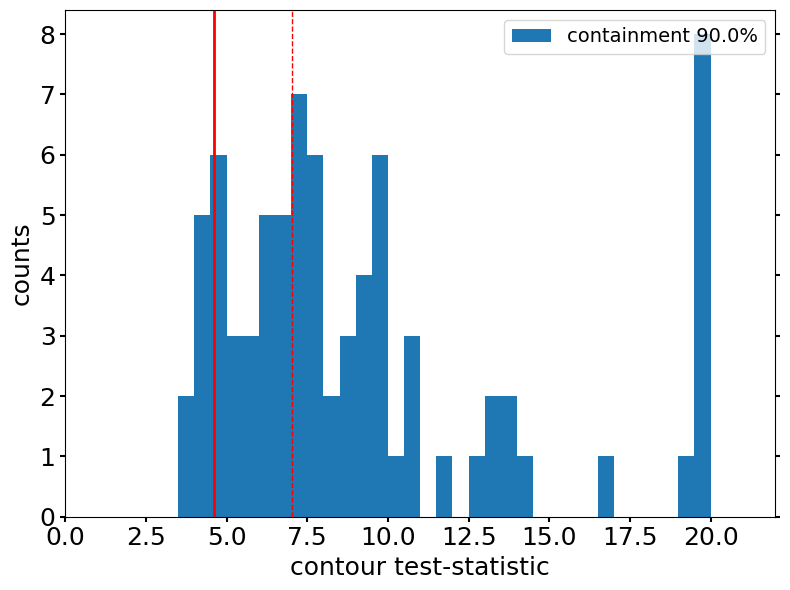

In [22]:
plt.figure(figsize=(8,6))
plt.hist(crit_vals, bins=bins_c, label=f'containment {pval*100}%')
plt.xlim([0.0, 22])
plt.legend(loc='upper right', fontsize=14)
plt.ylabel('counts', fontsize=18)
plt.xlabel('contour test-statistic', fontsize=18)

ax = plt.gca()
ax.axvline(x=chi2.isf(1-pval, 2), color='red', lw=2)
ax.axvline(x=chi2.isf(1-pval, 3.5), color='red', lw=1, linestyle='dashed')
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=18)
ax.yaxis.set_ticks_position('both')
plt.tight_layout()
plt.show()

In [23]:
def GreatCircleDistance(azi_1, zen_1, azi_2, zen_2):
        ra_1 = azi_1
        ra_2 = azi_2
        dec_1 = np.pi/2.0 - zen_1
        dec_2 = np.pi/2.0 - zen_2
        '''Compute the great circle distance between two events'''
        '''All coordinates must be given in radians'''
        delta_dec = np.abs(dec_1 - dec_2)
        delta_ra = np.abs(ra_1 - ra_2)
        x = (np.sin(delta_dec / 2.))**2. + np.cos(dec_1) *\
            np.cos(dec_2) * (np.sin(delta_ra / 2.))**2.
        return 2. * np.arcsin(np.sqrt(x))

In [24]:
gcds = []
gcds_corr = []
for event_id in succ_ids:
    dat_filter_prepulse = np.load(os.path.join(bp, "filter_prepulse", f"mincoords_event_{event_id}_padded_input.npy"))
    dat_filter_prepulse_corr = np.load(os.path.join(bp, "sigma_0.7", f"mincoords_event_{event_id}_padded_input.npy"))
    true = np.load(os.path.join(bp, "original", f"truecoords_event_{event_id}_padded_input.npy"))[0]
    true_zen, true_azi = true[0], true[1]
    reco_zen_corr, reco_azi_corr = dat_filter_prepulse_corr[:, 0], dat_filter_prepulse_corr[:, 1]
    reco_zen, reco_azi = dat_filter_prepulse[:, 0], dat_filter_prepulse[:, 1]
    gcd_corr = np.median(GreatCircleDistance(true_azi, true_zen, reco_azi_corr, reco_zen_corr))
    gcd = np.median(GreatCircleDistance(true_azi, true_zen, reco_azi, reco_zen))
    gcds.append(gcd)
    gcds_corr.append(gcd_corr)
    

(0.0, 1.3)

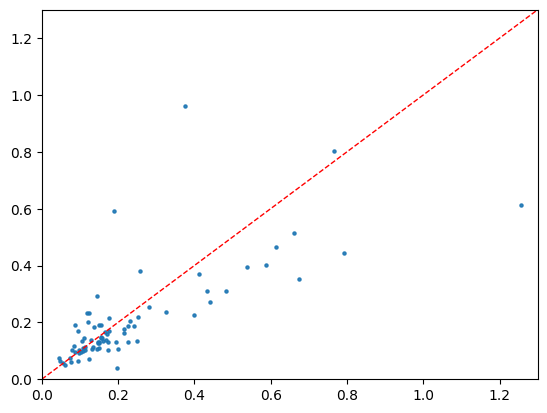

In [27]:
plt.figure()
plt.scatter(np.rad2deg(gcds), np.rad2deg(gcds_corr), s=5, alpha=0.9)
plt.plot([0.0, 1.3], [0.0, 1.3], "r--", lw=1)
plt.ylim([0.0, 1.3])
plt.xlim([0.0, 1.3])